# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [322]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly

from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.join('..','..'))
import toolkit as tk

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [323]:
real_instances, simulated_instances, drawn_instances = tk.get_all_labels_and_files()
real_instances = pd.DataFrame(real_instances, columns=['label', 'path'])
df = tk.load_instance(real_instances[real_instances.label==0].iloc[0])
print(real_instances[real_instances.label==0].iloc[0].path)
df

D:\OneDrive\Documents\UOC\TFM\3W\overviews\_baseline\..\..\dataset\0\WELL-00001_20170201020207.csv


,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,NaN,0.0,0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-01 06:59:56,0,WELL-00001,20170201020207,0.0,10014690.0,119.0453,1504822.0,83.44021,1567749.0,NaN,0.0,0
2017-02-01 06:59:57,0,WELL-00001,20170201020207,0.0,10014690.0,119.0452,1510422.0,83.45413,1567749.0,NaN,0.0,0
2017-02-01 06:59:58,0,WELL-00001,20170201020207,0.0,10014690.0,119.0451,1516023.0,83.46806,1567750.0,NaN,0.0,0


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

[]

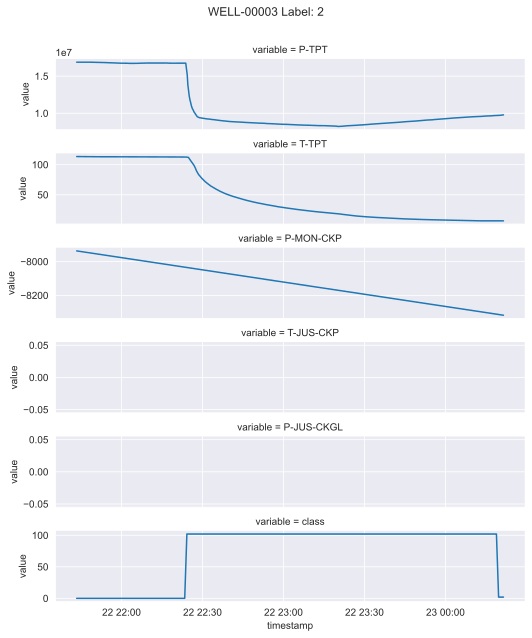

In [325]:
df = tk.load_instance(real_instances[real_instances.label==2].iloc[1])

flist = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL']

df_long = pd.melt(df[flist+['class']], ignore_index=False)

sns.set_style("darkgrid")

rel = sns.relplot(data=df_long, x=df_long.index, y='value', row='variable', kind='line', height=1.5, aspect=5, 
            facet_kws=dict(sharey=False))

rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('{} Label: {}'.format(df.well[0], df.label[0]))

plt.plot()

In [ ]:
scale = StandardScaler()
df_scal = pd.DataFrame(scale.fit_transform(df[flist]), columns=flist, index=df.index)

df_long_scal = pd.melt(df_scal, ignore_index=False)

sns.set_style("darkgrid")

sns.relplot(data=df_long_scal, x=df_long_scal.index, y='value', row='variable', kind='line', height=1.5, aspect=5, 
            facet_kws=dict(sharey=False))
plt.plot()

In [ ]:
i = 0
for t, r in df[flist].iterrows():
    print(t, r.to_dict())
    i += 1
    if i > 5:
        break

In [172]:

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.RobustScaler()

rmean = stats.RollingMean(window_size=900)
rSEM = stats.RollingSEM(ddof=1, window_size=900)
rMax = stats.RollingMax(window_size=900)
rMin = stats.RollingMin(window_size=900)
rtree = tree.HoeffdingTreeClassifier()
rlr = linear_model.LogisticRegression(optimizer=optim.SGD(.1))
#metric = metrics.Accuracy()
metric = metrics.ClassificationReport()

model = compose.Select(flist[0])
for f in flist:
    model += fx.Agg(on=f, by = None, how=rmean)
    model += fx.Agg(on=f, by = None, how=rSEM)
    model += fx.Agg(on=f, by = None, how=rMax)
    model += fx.Agg(on=f, by = None, how=rMin)
model |= compose.Discard(flist[0])
model |= scaler
model |= rtree

df_clean = df[flist+['class']].dropna()

In [170]:
evaluate.progressive_val_score(stream.iter_pandas(df_clean[flist], df_clean['class']), model, metric)

C:\ProgramData\Anaconda3\envs\3W\lib\site-packages\river\stats\sem.py:89: RuntimeWarning: invalid value encountered in double_scalars
  return (super().get() / len(self._rolling_mean.window)) ** 0.5


           Precision   Recall    F1       Support  
                                                   
     0.0      98.45%   100.00%   99.22%      3755  
     2.0     100.00%    99.52%   99.76%        21  
   102.0      99.98%    98.84%   99.41%      5096  
                                                   
   Macro      99.48%    99.46%   99.46%            
   Micro      99.34%    99.34%   99.34%            
Weighted      99.35%    99.34%   99.34%            

                  99.34% accuracy                  

In [154]:
np.unique(df['class'], return_counts=True)

(array([  0.,   2., 102.,  nan]), array([3756,  210, 5096,   59], dtype=int64))

In [168]:
model = model.clone()
evaluate.progressive_val_score(
    model = model,
    dataset = stream.iter_pandas(df_clean[flist], df_clean['class']),
    metric = metrics.Accuracy(),
    delay = 0, 
    print_every = 900)

C:\ProgramData\Anaconda3\envs\3W\lib\site-packages\river\stats\sem.py:89: RuntimeWarning: invalid value encountered in double_scalars
  return (super().get() / len(self._rolling_mean.window)) ** 0.5


[900] Accuracy: 100.00%
[1,800] Accuracy: 100.00%
[2,700] Accuracy: 100.00%
[3,600] Accuracy: 100.00%
[4,500] Accuracy: 98.69%
[5,400] Accuracy: 98.91%
[6,300] Accuracy: 99.06%
[7,200] Accuracy: 99.18%
[8,100] Accuracy: 99.27%
[9,000] Accuracy: 99.33%


Accuracy: 99.34%

## Drift test

In [299]:
# Auxiliary function to plot the data
def plot_data(stream, sts, warnings=None, drifts=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)
    ax1.grid; ax2.grid
    ax1.set_ylabel('Stream'); ax2.set_ylabel('Stat')
    fig.suptitle('Drift test')
    ax1.plot(stream, label='Stream')
    ax2.plot(sts, label='stats')
    if drifts is not None:
        for drift_detected in drifts:
            ax2.axvline(stream.index[drift_detected], color='red', linewidth=0.5)
    if warnings is not None:
        for warning_detected in warnings:
            ax2.axvline(stream.index[warning_detected], color='green', linewidth=0.25)
    plt.show()

In [312]:
df = tk.load_instance(real_instances[real_instances.label==3].iloc[0])
df_clean = df[flist+['class']].dropna()

#sem = stats.RollingSEM(ddof=1, window_size=30)
sem = stats.SEM()

f = 'P-TPT'
#drift_detector = drift.ADWIN(delta=0.002)
drift_detector = drift.DDM(min_num_instances=600)
warnings = []
drifts = []
sems = []

for i, val in enumerate(df_clean[f]):
    sems.append(sem.update(val).get())
    in_drift, in_warning = drift_detector.update(sems[-1])   # Data is processed one sample at a time
    if in_warning:
        # The drift detector indicates after each sample if there is a drift in the data
        #print(f'Change detected at index {i}')
        warnings.append(i)
#        drift_detector.reset()   # As a best practice, we reset the detector
    if in_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}, {x}')
        drifts.append(i)
#        drift_detector.reset()   # As a best practice, we reset the detector

plot_data(df_clean[f], pd.Series(sems, index=df_clean.index), warnings=warnings, drifts=drifts)

ValueError: math domain error

In [313]:
sems

[0.0, 155.0]

## Anomaly detector

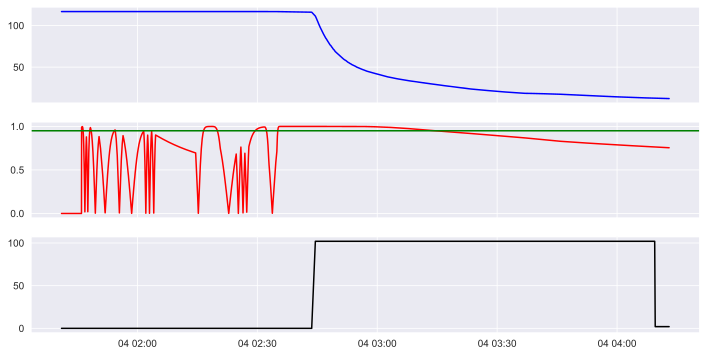

In [258]:
df = tk.load_instance(real_instances[real_instances.label==2].iloc[0])
df_clean = df[flist+['class']].dropna()

f = 'T-TPT'

detector = anomaly.GaussianScorer(window_size=None, grace_period=300)

anomalies = []

for i, val in enumerate(df_clean[f]):
    anomalies.append(detector.score_one(None, val))
    detector = detector.learn_one(None, val)
anomalies = pd.Series(anomalies, index=df_clean.index)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
ax1.grid
ax2.grid
ax3.grid
ax1.plot(df_clean[f], label='Stream', color='blue')
ax2.plot(anomalies, label='Anomalies prob', color='red')
ax2.axhline(0.95, color='green')
ax3.plot(df_clean['class'], label='class', color='black')

plt.tight_layout
plt.show()